In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

# imports
import random
import math

import numpy as np
import scipy
import scipy.misc
import scipy.integrate
import pandas as pd

import torch

import torch.nn
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.patheffects
from sith import SITH
import seaborn as sn
sn.set_context("poster")

cuda


# Test 1: Basic signal through time. 

We are testing a SITH setup on a 1 second scale and adding in an input signal 
that occurs for one time step and viewing what that singal looks like through 
time in both Lapace space and inverse-Lapace space. 

In [3]:
# The SITH layer has a lot of different parameters that allow you to fine 
# tune exactly how compressed you want the historical representation to be.
#     Parameters
#     ----------
#     in_features: int
#         Number of tracked features
#     tau_0: float (default = 1)
#         The center of the first receptive field in inverse-Lapace space. 
#     dt: float (optional, default=None)
#         The presentation time-delta of each stimulus to the representation.
#         Likely to be the same value as tau_0, unless you want more granular
#         control of how things are presented to the representation. 
#     k: int
#         The spcificity of the receptive fields
#     c: float
#         The degree of historical compression. Smaller numbers means greater
#         numbers of tau*s will be dedicated to tracking the more recent past
#     alpha: float
#         
#     ntau: int
#         The desired number of taustars in the final representation, before
#         indexing with T_every
#     T_every: int
#         How many tau*s we skip when indexing into the inverse-laplace space
#         representation, T.
#
#############################################################################


sith_params ={"in_features":10,
              "tau_0":1, "k":4,
              "c":.05, "ntau":100, 
              "dt":.1, 
              "T_every":8, "alpha":1.0}

sithrep = SITH(**sith_params)
sithrep.cuda()
target_vec = torch.ones(1, 10).type(torch.cuda.DoubleTensor)
taustars = sithrep._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']].detach().cpu().numpy()
input_scale = 10
print(taustars)

[  1.           1.47745544   2.18287459   3.22509994   4.76494147
   7.03998871  10.40126965  15.36741246  22.7046672   33.54513415
  49.56144107  73.22482091 108.18641027]


In [4]:
target_vecs = torch.cat((target_vec, 
                         torch.zeros(39,10).type(torch.DoubleTensor).cuda()), 
                        dim=0)
print(target_vecs.shape)

torch.Size([40, 10])


cuda:0


Text(0.5,1,'One feature through time')

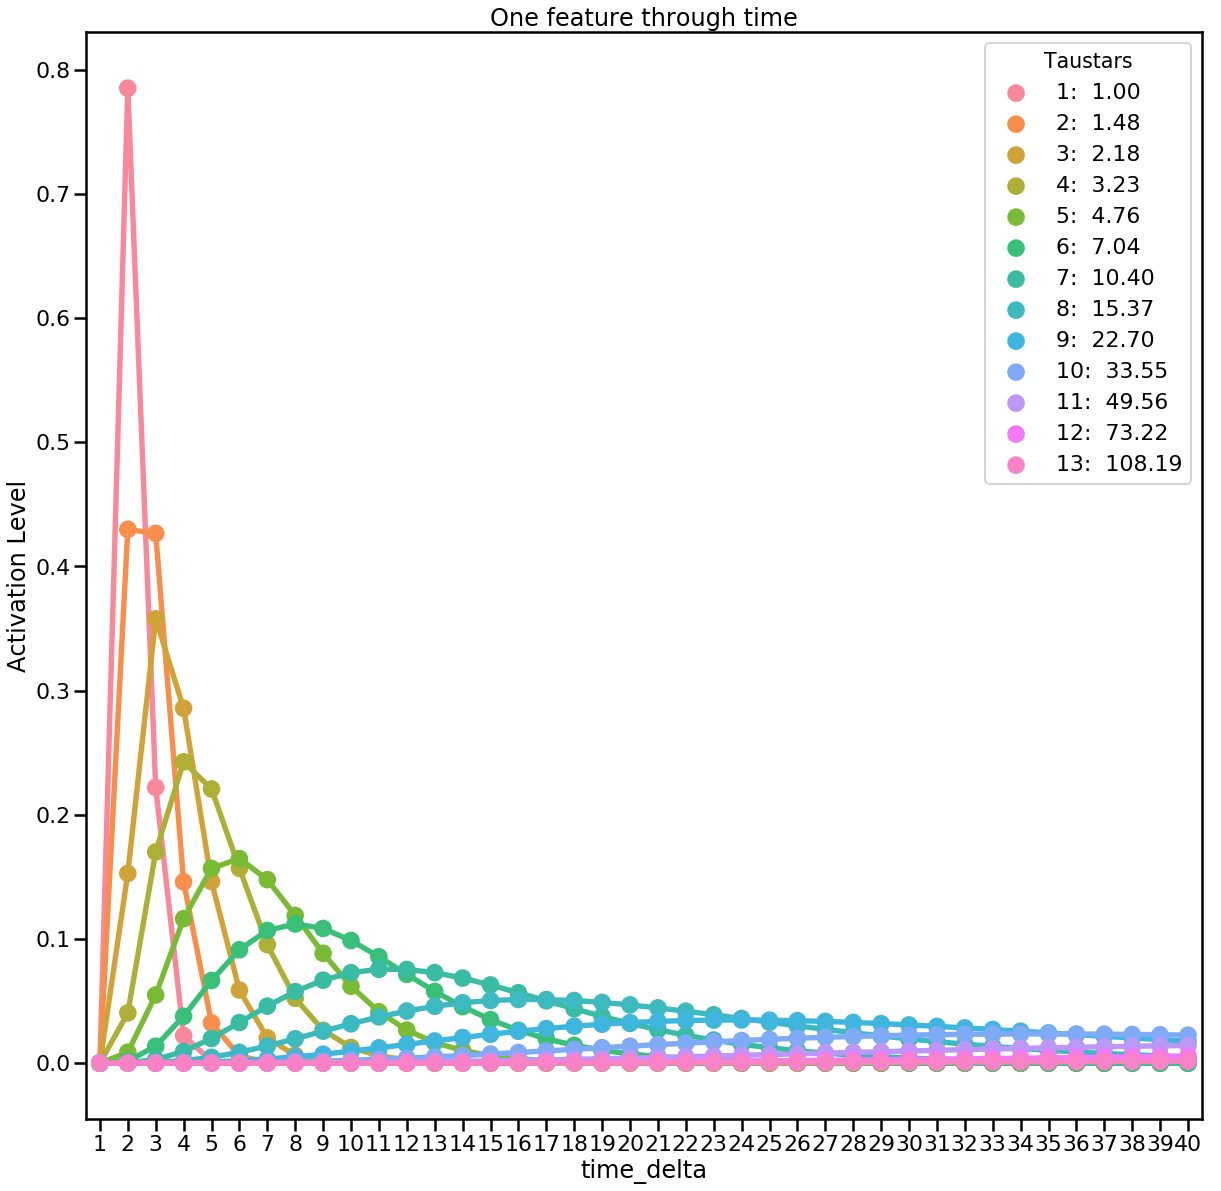

In [5]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs)
print(Ts.device)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append("%i:  %.2f" % (i+1,taustars[i]))
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig=figure(figsize=(20,20))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")

In [6]:

sith_params ={"in_features":10,
              "tau_0":1, "k":4,
              "c":.05, "ntau":100, 
              "dt":.1, "g":1,
              "T_every":8, "alpha":1.0}

sithrep = SITH(**sith_params)
sithrep.cuda()
target_vec = torch.ones(1, 10).type(torch.cuda.DoubleTensor)
taustars = sithrep._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']].detach().cpu().numpy()
input_scale = 10
print(taustars)

[  1.           1.47745544   2.18287459   3.22509994   4.76494147
   7.03998871  10.40126965  15.36741246  22.7046672   33.54513415
  49.56144107  73.22482091 108.18641027]


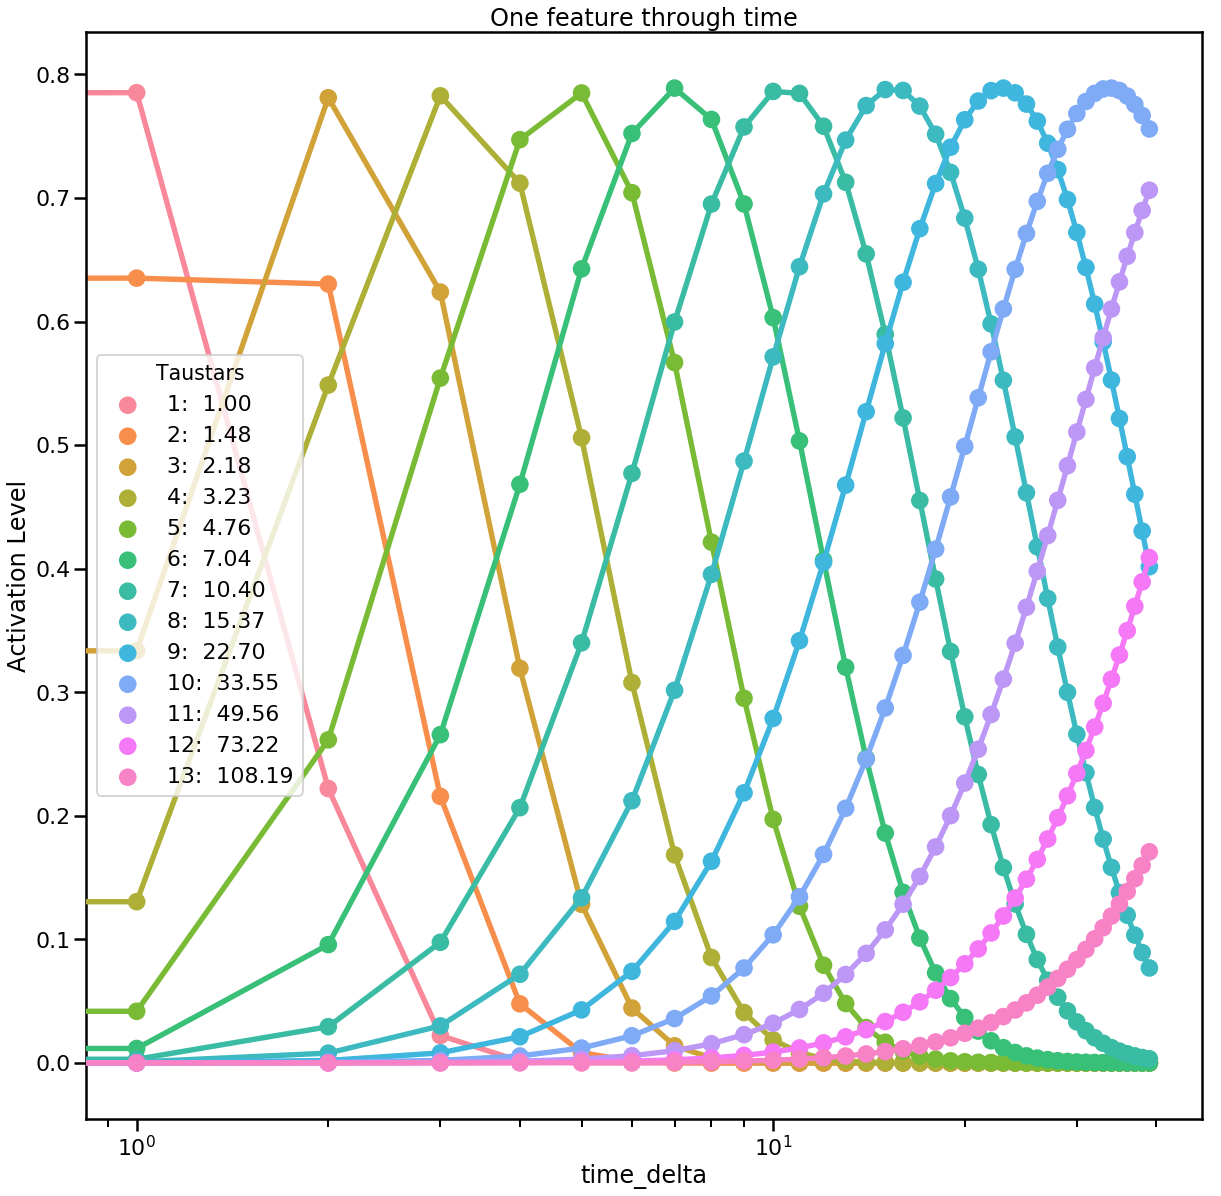

In [7]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append("%i:  %.2f" % (i+1,taustars[i]))
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig=figure(figsize=(20,20))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")
xscale("log")

#  Test 2: two inputs

In [8]:

sith_params ={"in_features":1,
              "tau_0":1, "k":4,
              "c":.05, "ntau":200, 
              "dt":.1, "g":0,
              "T_every":8,"alpha":1.0}

sithrep = SITH(**sith_params)
sithrep.cuda()
target_vec = torch.ones(1, sith_params['in_features']).type(torch.cuda.DoubleTensor)
taustars = sithrep._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']].detach().cpu().numpy()
input_scale = 10
print(taustars)

[1.00000000e+00 1.47745544e+00 2.18287459e+00 3.22509994e+00
 4.76494147e+00 7.03998871e+00 1.04012696e+01 1.53674125e+01
 2.27046672e+01 3.35451342e+01 4.95614411e+01 7.32248209e+01
 1.08186410e+02 1.59840601e+02 2.36157366e+02 3.48911986e+02
 5.15501913e+02 7.61631107e+02 1.12527603e+03 1.66254519e+03
 2.45633644e+03 3.62912765e+03 5.36187440e+03 7.92193052e+03
 1.17042994e+04]


In [9]:
target_vecs = torch.cat((target_vec, 
                         torch.zeros(10,sith_params['in_features']).type(torch.DoubleTensor).cuda(),
                         target_vec,
                         torch.zeros(26,sith_params['in_features']).type(torch.DoubleTensor).cuda(),), 
                        dim=0)
print(target_vecs.shape)

torch.Size([38, 1])


Text(0.5,1,'One feature through time')

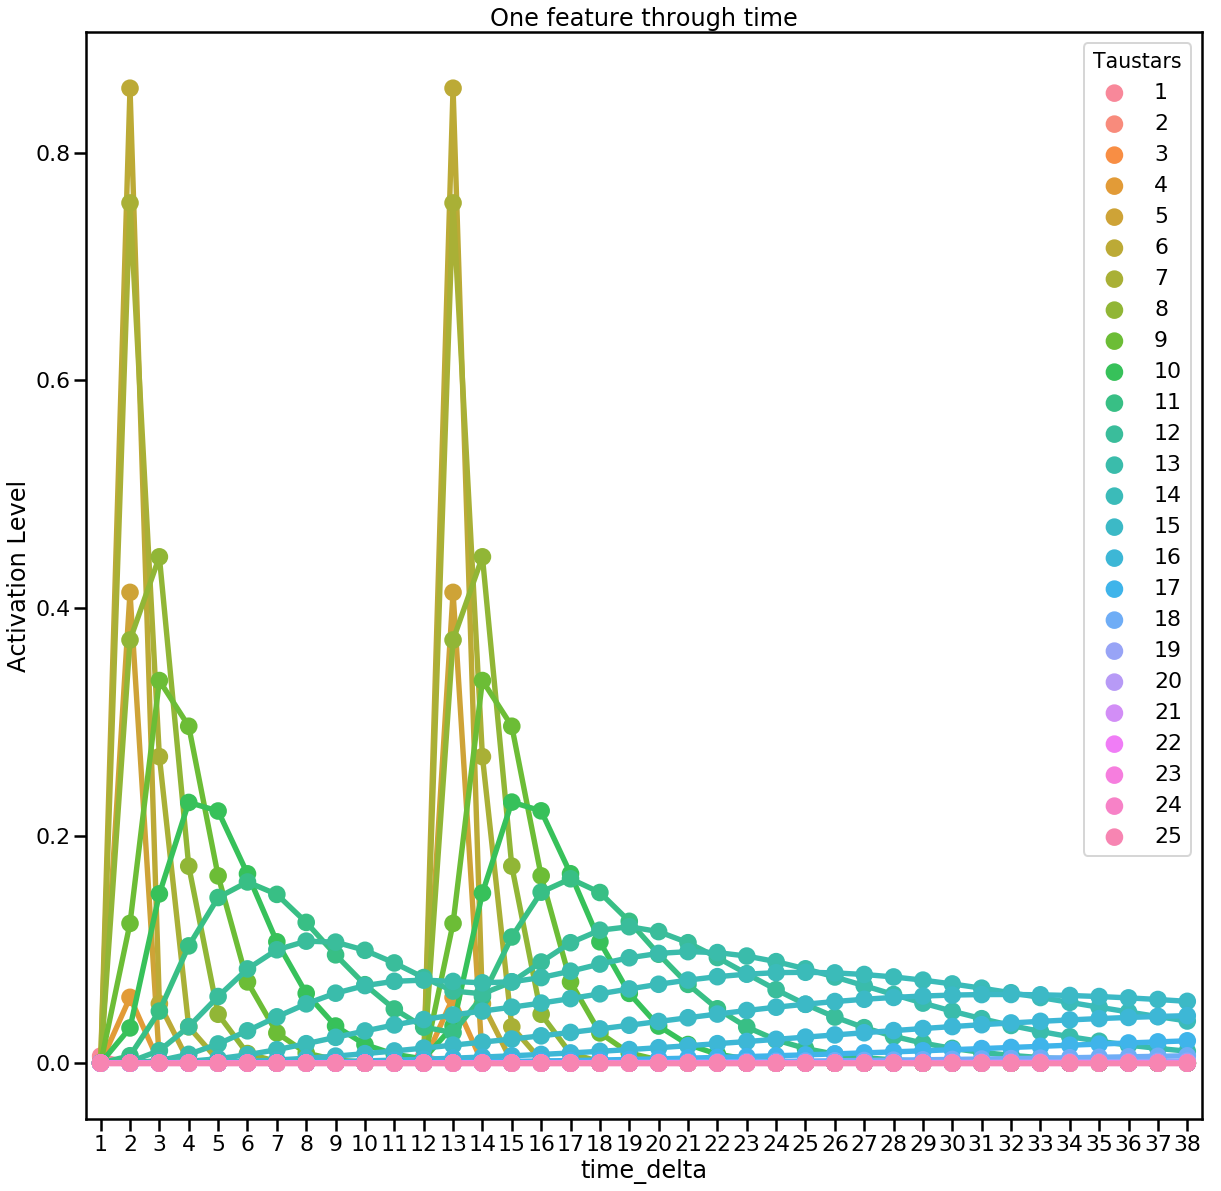

In [10]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs, dur=10)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append(i+1)
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig=figure(figsize=(20,20))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")


Text(0.5,0.92,'ftilde2 as a function of dts')

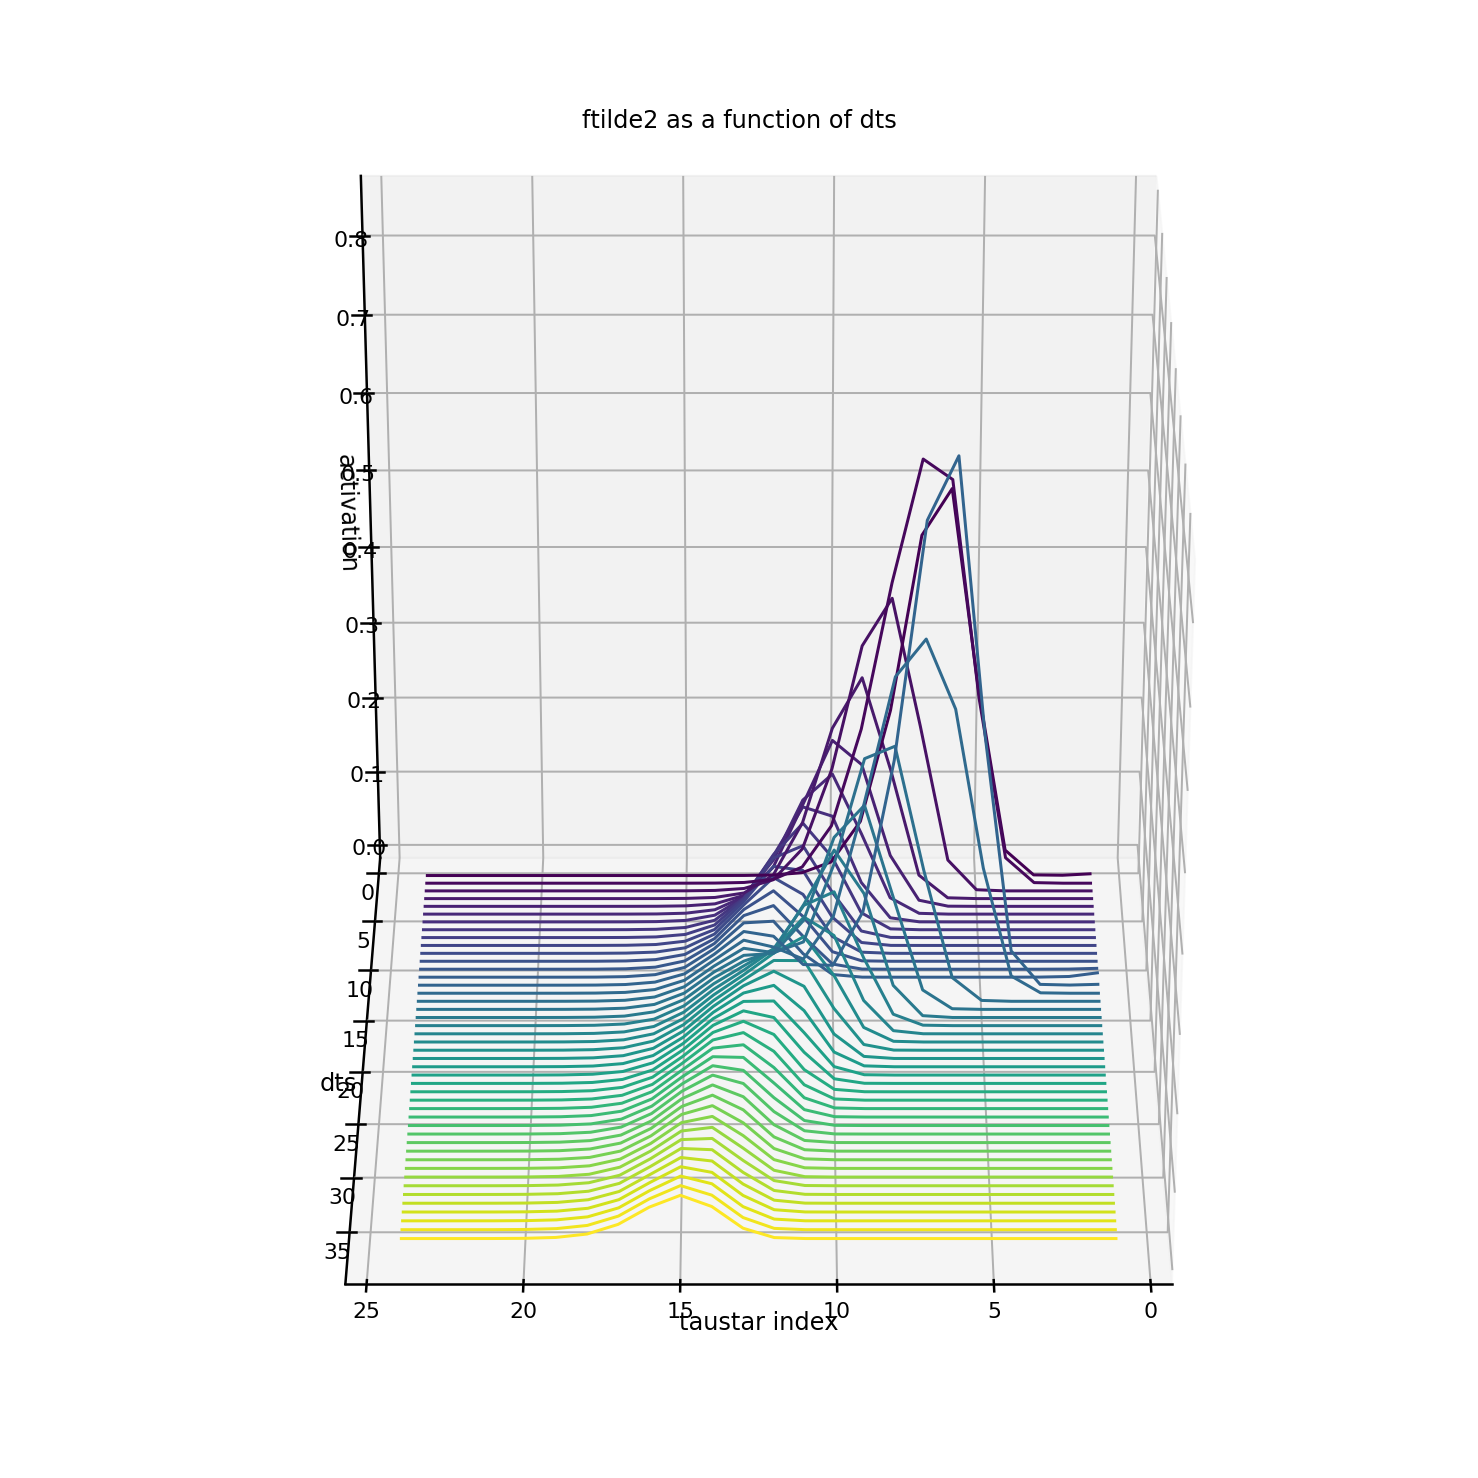

In [11]:

from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = figure(figsize=(20,20))
def f(x, y):
    return float(sdat.loc[(sdat.Taustars==int(x))&(sdat.time_delta==int(y)), "data"])

x = list(range(1,max(sdat.Taustars)))
y = list(range(1,max(sdat.time_delta)))
Z = []
for X in x:
    Z.append([])
    for Y in y:
        Z[-1].append(f(X, Y))
X, Y = np.meshgrid(x, y)
Z = np.array(Z).transpose(1,0)

ax = Axes3D(fig)
ax.contour3D(X, Y, Z, 50,zdir="y", cmap='viridis')
ax.view_init(30,90)
ax.set_xlabel("taustar index")
ax.set_ylabel("dts")
ax.set_zlabel("activation")
ax.set_title("ftilde2 as a function of dts")